## Table of Contents:
#### 01. Importing the libraries and data
#### 02. Time-series analysis decomposition
#### 03. Testing for Stationarity (Dickey-Fuller Test)
#### 04. Stationarizing the Time Series Data

## 01. Importing the libraries and data

In [1]:
# importing the libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import statsmodels.api as sm 

import os

# This is a library that handles warnings.
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. 

In [2]:
# configuring the API key

quandl.ApiConfig.api_key = 'zy2W-dKaxtzjxDnXfRGA'

In [3]:
# Importing the 'Consumer Price Index - Germany' variable from the 'Inflation Rates' dataset

data = quandl.get('RATEINF/CPI_DEU')

In [4]:
data.head()

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [11]:
data.tail()

,Value
Date,
2023-04-30,116.6
2023-05-31,116.5
2023-06-30,116.8
2023-07-31,117.1
2023-08-31,117.5


In [5]:
data.shape

(392, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

As the dataset contains data from 1991 to 2023, which I think is quite relevant for my analysis, so I have considered the whole dataset and haven't taken any subset.

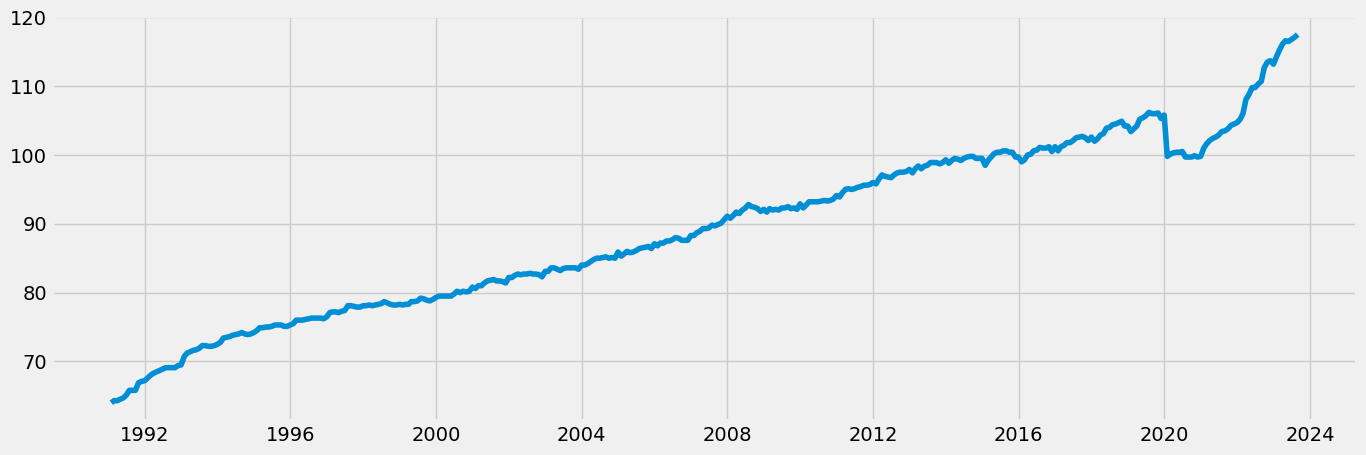

In [7]:
# Plotting the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

In [8]:
# checking for missing values

data.isnull().sum()

Value    0
dtype: int64

In [15]:
pd.options.display.max_rows=None

## 02. Time-series analysis decomposition

In [17]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [18]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

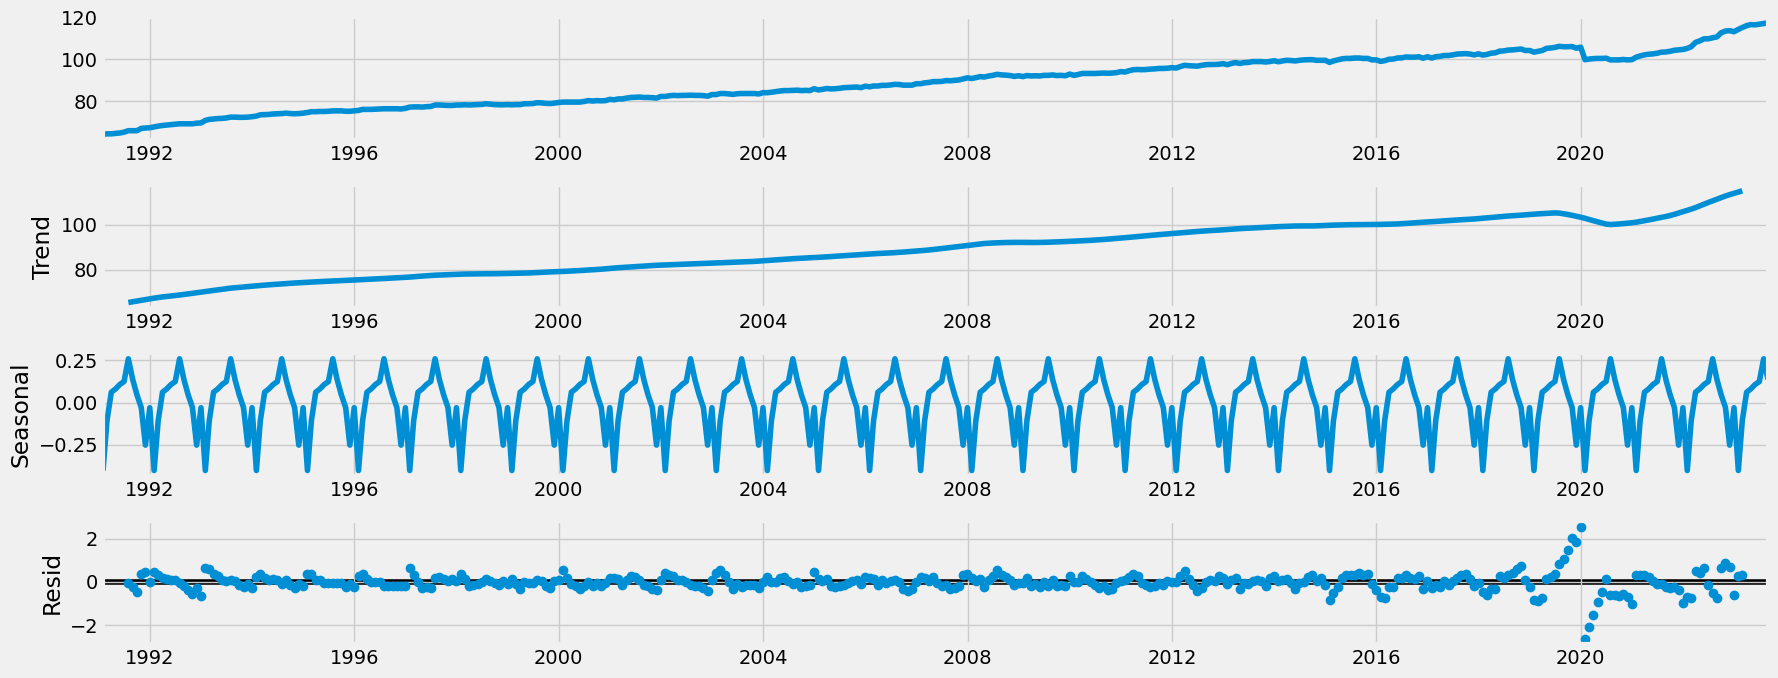

In [19]:
# Plotting the separate components

decomposition.plot()
plt.show()

## 03. Testing for Stationarity (Dickey-Fuller Test)

In [20]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

# Importing the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Defining the function
def dickey_fuller(timeseries): 
    # Performing the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Applying the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.445036
p-value                          0.983103
Number of Lags Used             12.000000
Number of Observations Used    379.000000
Critical Value (1%)             -3.447722
Critical Value (5%)             -2.869196
Critical Value (10%)            -2.570849
dtype: float64


The Test Statistic is much larger than the Critical Value(5%), so we cannot reject the null hypothesis, which means there is a unit root in the data and the data is non-stationary. So we must stationarize the data before forecasting.

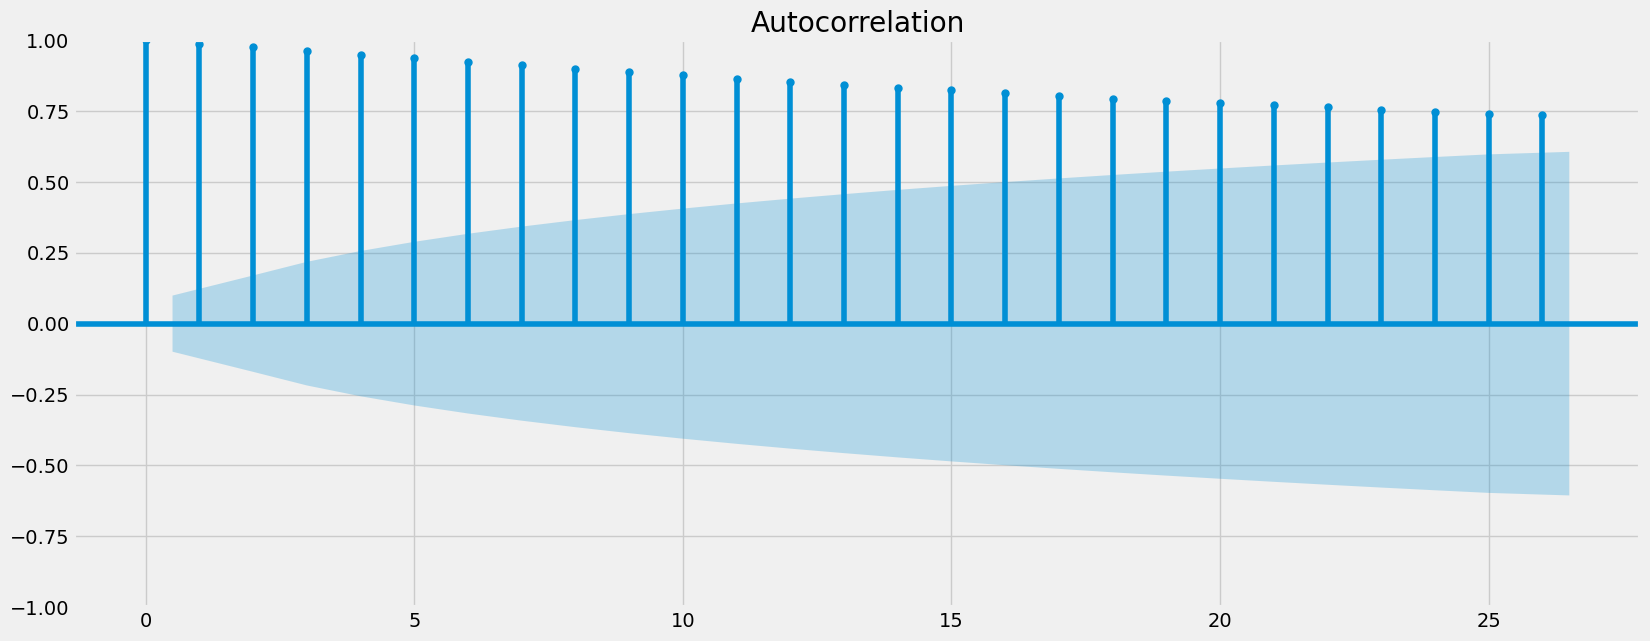

In [21]:
# Checking out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

Here all the lags are beyond the confidence interval, which means all the lags are correlated to each other. Hence it supports the result of the Dickey-Fuller test and is proved once again that the data is non-stationary.

## 04. Stationarizing the Time Series Data

In [22]:
data_diff = data - data.shift(1)

In [23]:
# removing the missing values that came about as a result of the differencing.

data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,Value
Date,
1991-02-28,0.3
1991-03-31,0.0
1991-04-30,0.2
1991-05-31,0.2
1991-06-30,0.4


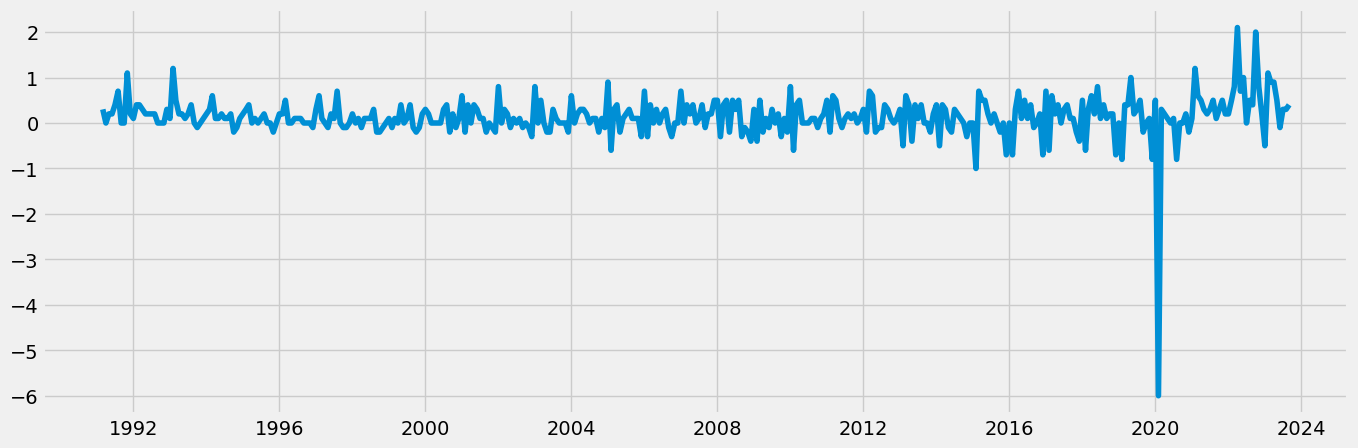

In [25]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
# performing the dickey-fuller test again

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.430342
p-value                          0.009967
Number of Lags Used             11.000000
Number of Observations Used    379.000000
Critical Value (1%)             -3.447722
Critical Value (5%)             -2.869196
Critical Value (10%)            -2.570849
dtype: float64


The test statistics is now smaller than the critical value(5%), which means that the data is stationary. Hence we can reject the null hypothesis. 

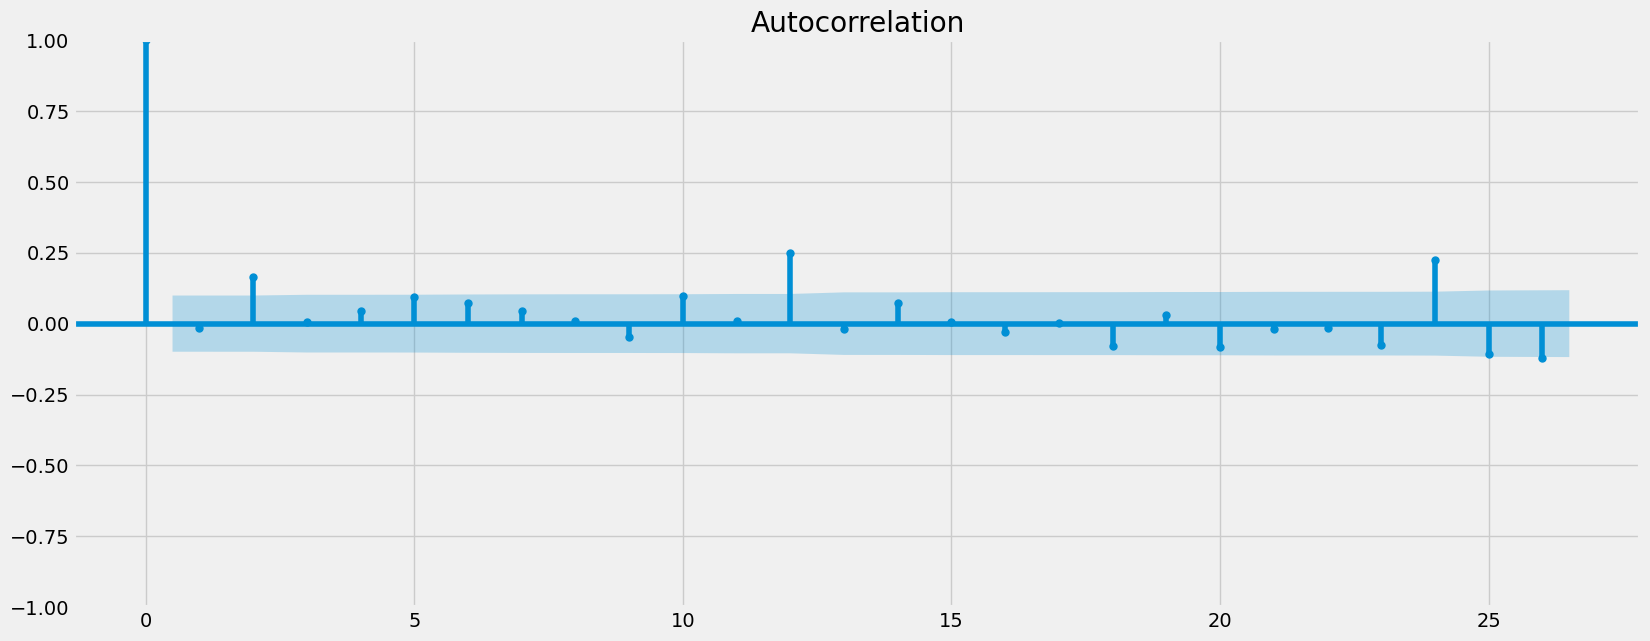

In [27]:
# replotting the autocorrelations

plot_acf(data_diff)
plt.show()

There are very few lags that are above the blue confidence interval (less than 10 lags), so stopping here.